# Úkol 3b

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shippy/czechitas-ai-data/blob/main/notebooks/assignment-03b.ipynb)

Pokud nebudete vědět, nezapomeňte se zeptat [pomocníčka pro tento úkol](https://chatgpt.com/g/g-67cab661ae5c8191b0d8419c76d3959b-czechitas-ai-in-data-analytics-2025-03)!

## Analýza článků v časopisu Guardian

V tomto notebooku se budeme věnovat zpracování nestrukturovaných dat, které jsou náhodně zvolenou podmnožinou [většího datasetu z Kaggle](https://www.kaggle.com/datasets/adityakharosekar2/guardian-news-articles?resource=download).

Nejprve nastavíme klienta pro OpenAI API. Toto nastavení se bude lišit v závislosti na tom, zda používáte Google Colab nebo spouštíte notebook na vlastním počítači, ale pokud následující dvě buňky proběhnou bez chyby, jste připraveni pokračovat.

In [ ]:
try:
    from google.colab import userdata
    _secret = userdata.get("OPENAI_API_KEY")
    %pip install pandas instructor openai python-dotenv rich
    !curl https://raw.githubusercontent.com/shippy/czechitas-ai-data/refs/heads/main/notebooks/guardian_100.csv > guardian_100.csv
except ImportError:
    import os
    from dotenv import load_dotenv
    _ = load_dotenv()
    _secret = os.environ.get("OPENAI_API_KEY")

In [2]:
import instructor
from openai import OpenAI
from rich import print

try:
    if not _secret:
        raise ValueError("API klíč nebyl nastaven!")
except NameError:
    print("Nastavte si API klíč v proměnné OPENAI_API_KEY a znovu spusťte *celý* notebook včetně předchozí buňky")

_client = OpenAI(api_key=_secret)
client = instructor.from_openai(_client)
test = client.chat.completions.create(
    messages=[
        {"role": "user", "content": "Hello, how are you? Respond with an emotion."},
    ],
    model="gpt-4o",
    response_model=str,
)
print(test)


/Users/simon/Documents/czechitas-ai-data/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I'm feeling enthusiastic and ready to assist you!

## Čtení dat

In [3]:
import pandas as pd

data = pd.read_csv('guardian_100.csv').head(10)
print(data.shape)
data.head()


(10, 7)

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
0,books/2022/may/24/margaret-atwood-handmaids-ta...,Books,Atwood responds to book bans with ‘unburnable’...,https://www.theguardian.com/books/2022/may/24/...,Amid political firestorms over books deemed by...,2022-05-24 14:52:56,147533
1,uk-news/2022/apr/29/eden-project-cornwall-inst...,UK news,Eden Project installs plastic grass to stop ch...,https://www.theguardian.com/uk-news/2022/apr/2...,The Eden Project in Cornwall has installed pla...,2022-04-29 09:24:02,144415
2,music/2018/jan/26/grammys-2018-jay-z-despacito...,Music,Who will – and should – win the major categori...,https://www.theguardian.com/music/2018/jan/26/...,"Album of the year Awaken, My Love! – Childish ...",2018-01-26 12:11:12,47554
3,technology/2018/apr/24/facebook-replacement-op...,Technology,Is Facebook replaceable? Tech investor launche...,https://www.theguardian.com/technology/2018/ap...,Can Facebook be replaced? The prominent Silico...,2018-04-24 19:35:23,53471
4,us-news/2019/jun/30/democrats-impeach-trump-pe...,US news,Democrats divided as pressure to impeach build...,https://www.theguardian.com/us-news/2019/jun/3...,In the House of Representatives the apparently...,2019-06-30 04:00:06,79238


## Úkoly

1. Vytvořte a implementujte prompt, který shrne každý z článků do jedné věty.
2. Vytvořte prompt, který z textu článku vytvoří strukturovaný výstup, ve kterém bude uvedeno, jakých lidí/entit se týká, do jaké z předdefinovaných kategorií (`data['sectionName'].unique().tolist()`) spadá, a jak urgentní popisuje situaci. Uložte tuto strukturu do nového sloupce `data['structured_output']`.
3. Udělejte graf častosti výskytu jednotlivých kategorií a jednotlivých entit. (Fantazii se meze nekladou - prodiskutujte to s pomocníčkem.)
4. Porovnejte výsledky klasifikace s původním sloupcem `data['sectionName']`. Jak velké úspěšnosti jste dosáhly?

## Ukázka

In [4]:
example = data[0:2]
outputs = []
for i, row in example.iterrows():
    print('Headline: ', row['webTitle'])
    output = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes news articles down to exactly one sentence."},
            {"role": "user", "content": row['bodyContent']},
        ],
        model="gpt-4o",
        response_model=str,
    )
    print('One-sentence summary: ', output)
    outputs.append(output)


Headline:  Atwood responds to book bans with ‘unburnable’ edition of Handmaid’s Tale

One-sentence summary:  Margaret Atwood has announced an "unburnable" edition of "The Handmaid’s Tale" to protest 
against censorship, which is being auctioned to support free expression, as political debates over controversial 
books continue.

Headline:  Eden Project installs plastic grass to stop children getting muddy

One-sentence summary:  Environmental campaigners criticize the widespread installation of plastic grass across the 
UK, including at the Eden Project, citing ecological harm, despite manufacturers' claims about benefits like air 
purification, as synthetic turf increases urban heat, releases microplastics, and exacerbates flood risks without 
supporting biodiversity.

## Úkol 1

Shrňte každý článek do jedné věty.

In [5]:
summaries = []
for idx, row in data.iterrows():
    summary = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes news articles down to exactly one sentence."},
            {"role": "user", "content": row['bodyContent']},
        ],
        model="gpt-4o",
        response_model=str,
    )
    summaries.append(summary)
data['oneSentenceSummary'] = summaries

## Úkol 2

Vytvořte prompt, který z textu článku vytvoří strukturovaný výstup, ve kterém bude uvedeno, jakých lidí/entit se týká, do jaké z předdefinovaných kategorií (`data['sectionName'].unique().tolist()`) spadá, a jak urgentní popisuje situaci. Uložte tuto strukturu do nového sloupce `data['structured_output']`.

In [6]:
from enum import Enum
from pydantic import BaseModel

def create_enum(name: str, values: list[str]) -> Enum:
    return Enum(name, {v.upper(): v for v in values})

CategoryEnum = create_enum('CategoryEnum', data['sectionName'].unique().tolist())

class ArticleSummary(BaseModel):
    summary: str
    entities: list[str]
    category: CategoryEnum
    urgency: int


outputs = []

for idx, row in data.iterrows():
    output = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes news articles and extracts entities, category and urgency."},
            {"role": "user", "content": row['bodyContent']},
        ],
        model="gpt-4o",
        response_model=ArticleSummary,
    )
    outputs.append(output)
data['structured_output'] = outputs




## Úkol 3

Vytvořte graf častosti výskytu jednotlivých kategorií a jednotlivých entit.


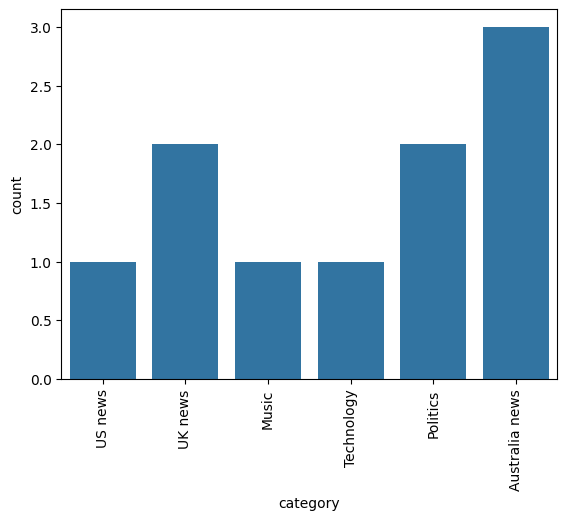

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

data['category'] = data['structured_output'].apply(lambda x: x.category.value)

sns.countplot(x='category', data=data)
# Set vertical rotation for x-axis labels
plt.xticks(rotation=90)
plt.show()




## Úkol 4

Porovnejte výsledky klasifikace s původním sloupcem `data['sectionName']`. Jak velké úspěšnosti jste dosáhly?

In [14]:
comparison = data['sectionName'] == data['category']
comparison.value_counts()

comparison.mean()

np.float64(0.7)